# Load

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
from scipy import integrate

import matplotlib.pyplot as plt

In [3]:
import importlib
ch = importlib.import_module('control_helper')

In [8]:
ch = importlib.reload(ch)

# Dynamics

(in the repo, there is an accompanying mathematica notebook to help check these results)

Solve the Hamilton equations of motion for the state variable X of the cartpole system to find the 1st order equation of motion $\dot{X} = f(X,t)$:

\begin{align}
    \dot{x}        &= \frac{- ml \cos(\theta) p_\theta + ml^2 p_x }{d(\theta)} \\
    \dot{p_x}      &= 0 \\
    \dot{\theta}   &= \frac{ (M+m) p_\theta - ml \cos(\theta) p_x }{d(\theta)} \\
    \dot{p_\theta} &= - \frac{l^2 m p_x^2 d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \cos (\theta ) d'(\theta )}{d(\theta )^2}+\frac{p_\theta^2 (m+M) d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \sin (\theta )}{d(\theta )}+g l m \sin (\theta )
\end{align}

with 
$d(\theta) = ml^2 (M + m \sin^2(\theta) )$

Use ode45 to time-evolve the dynamical system, and make a movie of the result.

Comments:
- Gravity is an optional parameter
- (An advantage of Hamilton's formalism) Friction will affect the px equation of motion only.

In [5]:
def make_movie(ctpl, x, th, time):
    xmin,xmax = [min(x)-2*ctpl.l, max(x)+2*ctpl.l]
    ymin,ymax = [-2*ctpl.l, 2*ctpl.l]
    for i,t in enumerate(time):
        if i%10==0:
            fig, ax = plt.subplots(1)
            ax.set_xlim([xmin,xmax])
            ax.set_ylim([ymin,ymax])
            ax.set_aspect('equal')

            # Pick data
            cm_pole = [x[i]+ctpl.l*np.sin(th[i]), ctpl.l*np.cos(th[i])]
            ax.plot(x[:i]+ctpl.l*np.sin(th[:i]), ctpl.l*np.cos(th[:i]), ls='--', lw=1)
            cm_cart = [x[i], 0]
            
            # Plot data
            ax.set_title(str(round(t, 2)), fontsize=20)
            ax.plot([cm_cart[0], 2*(cm_pole[0]-cm_cart[0])+cm_cart[0]], [cm_cart[1], 2*cm_pole[1]], c='k')
            ax.scatter(*cm_pole, marker='o', c='k')
            ax.scatter(*cm_cart, marker='s', s=500, c='k')
            ax.axis('off')

            plt.close() # prevent print
            ch.DisplayFigure(fig)

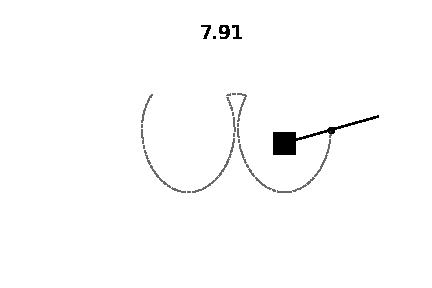

In [21]:
# c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2, 'length_pole': .75, 'gravity': 1})
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1})
y0 = [0, 1, 0, 0]
tmin, tmax = [0,8]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
make_movie(c, x,th, time)

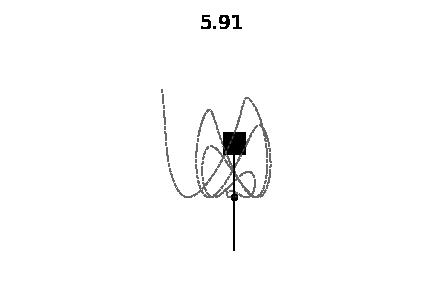

In [55]:
c = ch.cartpole({'mass_cart': 1, 'mass_pole': 3, 'length_pole': .75, 'gravity': 10, 'friction': 10})

y0 = [0, 5, 0, 0]
tmin, tmax = [0,6]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
make_movie(c, x,th, time)

# Controllability

Find the fixed points of the dynamics. Then, compute the Jacobian and evaluate the result at the fixed points of 
$p_x \rightarrow 0, p_\theta \rightarrow 0, \theta \rightarrow 0, \pi$:

\[
    J = \left(
    \begin{array}{cccc}
     0 & \frac{1}{M} & 0 & -\frac{1}{l M} \\
     0 & -\frac{\eta }{M} & 0 & \frac{\eta }{l M} \\
     0 & -\frac{1}{l M} & 0 & \frac{m+M}{l^2 m M} \\
     0 & 0 & g l m & 0 \\
    \end{array}
    \right)
\]

The variable $s$ holds the sign associated with $\pi \Rightarrow s = -1$ and $0 \Rightarrow s = 1$. The $\eta$ refers to friction.

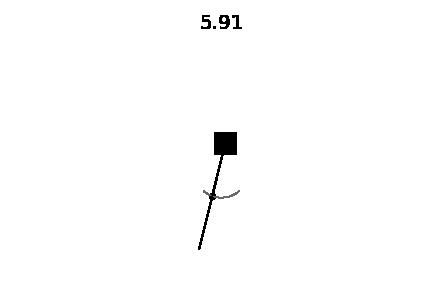

In [65]:
# Stable fixed point
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1})

tmin, tmax = [0,6]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
                   
yf = np.array([0, 0,np.pi,0])
y0 = np.array([0, 0,np.pi+0.5,0])

linear_res = np.array([sp.linalg.expm(c.A(-1) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
                   
make_movie(c,x,th,time)                  

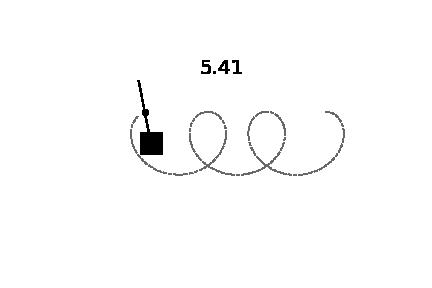

In [66]:
# Unstable fixed point! We want to control this.
tmin, tmax = [0, 5.5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
                   
yf = np.array([0, 0,0,0])
y0 = np.array([0, 0,0.001,0])

linear_res = np.array([sp.linalg.expm(c.A(1) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
                   
make_movie(c,x,th,time) 

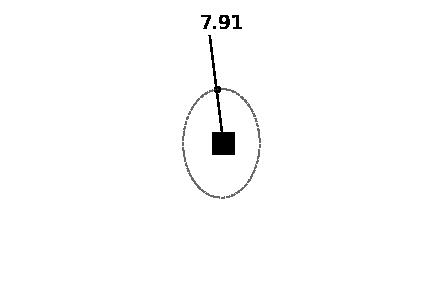

In [64]:
# Notice the correct dynamics for our unstable fixed point do not spiral away.
tmin, tmax = [0, 8]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
                   
y0 = np.array([0, 0,0.001,0])

res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
make_movie(c, x,th, time)

In [ ]:
# Check for controllability by looking at the rank of the controllability matrix
# Look at the SVD and interpret
C_gram = [c.A]

In [2]:
# Check the behavior of placing eigenvalues deeper into the negative half-plane

In [ ]:
# Run the lqr for choice of Q and R to find the optimal regulator
# Look at the eigenvalues to learn what optimal control is doing
# Should see that xdot and thetadot are VERY controllable.

# Observability

In [ ]:
# Choose a sensor (let's say the position, x)
# Construct the observability matrix and check for observability
# Look at the SVD and interpret

In [ ]:
# Is there an observable subsystem? Omit x.